The purpose of this notebook is to conduct baseline modeling and extended modeling

Table of Contents

[b.1 ARIMA model on store 1 transaction](#b.1)

[b.2 Time-implicit regression model on store 1 transaction](#b.2)

[b.3 Time-implicit regression model on store transactions](#b.3)

[b.4 Random Forest, XGBoost, LightGBM, Linear Regression, prophet models on store transactions](#b.4)

[b.5 Auto-ml on store transactions](#b.5)

[b.6 Summary](#b.6)

In [3]:
%store -r oil_df stores_df transactions_df holidays_events_df train_df

<a id="b.1"></a>
## b.1 ARIMA model on store 1 transaction

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarnin

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWar

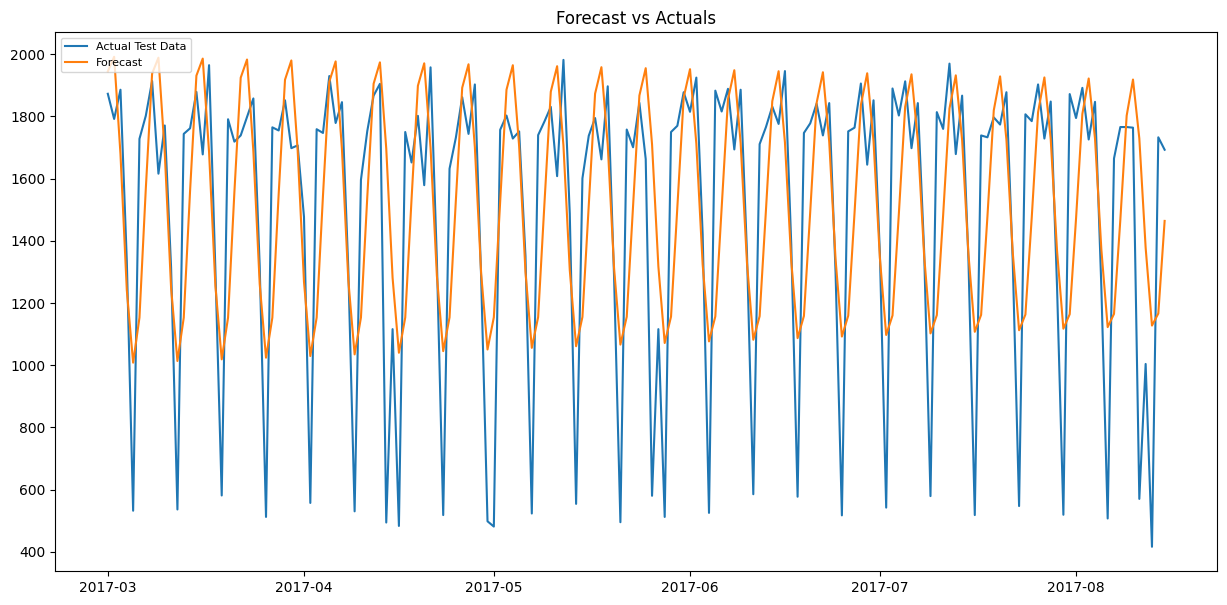

Best ARIMA Order: (2, 0, 2)
Best ARIMA AIC: 22752.17009872867
Test MSE: 142209.00480594166
Test RMSE: 377.10609224188045
Test MAPE: 30.587071285648886
R-squared: 0.3739750671062686


In [1]:
#Apply the classical time series forecast on the transactions of store 1
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate MAPE
def calculate_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load the dataset
df = pd.read_csv('/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/store_1_transactions_final.csv')

# Convert 'date' to datetime, and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Split the dataset
train = df.loc[:'2017-02-28']
test = df.loc['2017-03-01':]

# Check for stationarity and determine 'd'
result = adfuller(train['transactions'])
d = 1 if result[1] > 0.05 else 0

# Initialize the best AIC to infinity, and best order to None
best_aic = float('inf')
best_order = None

# Grid search for p, d, q values
# To find the model with the lowest AIC value. A lower AIC indicates a better model fit
for p in range(3):
    for q in range(3):
        try:
            # Attempt to create and fit the ARIMA model
            model = ARIMA(train['transactions'], order=(p, d, q))
            model_fit = model.fit()
            # If the current model's AIC is lower than the best AIC, update best AIC and best order
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p, d, q)
        except:
            continue

# Fit the best ARIMA model to the dataset
best_model = ARIMA(train['transactions'], order=best_order)
best_model_fit = best_model.fit()

# Make predictions on the test set
forecast = best_model_fit.get_forecast(steps=len(test))
forecast_index = test.index
forecast_values = forecast.predicted_mean

# Calculate metrics
mse = mean_squared_error(test['transactions'], forecast_values)
rmse = np.sqrt(mse)
mape = calculate_mape(test['transactions'], forecast_values)
r_squared = r2_score(test['transactions'], forecast_values)


# Plot the results
plt.figure(figsize=(15, 7))
# plt.plot(train['transactions'], label='Training Data')
plt.plot(test['transactions'], label='Actual Test Data')
plt.plot(forecast_index, forecast_values, label='Forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Output the results
print(f'Best ARIMA Order: {best_order}')
print(f'Best ARIMA AIC: {best_aic}')
print(f'Test MSE: {mse}')
print(f'Test RMSE: {rmse}')
print(f'Test MAPE: {mape}')
print(f'R-squared: {r_squared}')


The above code is applied on the transaction of store 1. It checks for stationarity, select the best ARIMA model through a grid search based on AIC, and making forecasts on a test dataset. MSE, RMSE, MAPE and R-squared are calculated.

<a id="b.2"></a>
## b.2 Time-implicit regression model on store 1 transaction

Ridge: {'RMSE': 292.37821622520835, 'MAPE': 20.47711441045901, 'R^2': 0.6427543168527929, 'Best Params': {'alpha': 100.0}}
RandomForestRegressor: {'RMSE': 115.90404315026194, 'MAPE': 6.1414508267613925, 'R^2': 0.9438597765076004, 'Best Params': {'max_depth': 10, 'n_estimators': 50}}
XGBRegressor: {'RMSE': 145.67341110655636, 'MAPE': 7.457087584881937, 'R^2': 0.9113175781365626, 'Best Params': {'max_depth': 5, 'n_estimators': 50}}
LGBMRegressor: {'RMSE': 144.42520373665698, 'MAPE': 8.209662859186468, 'R^2': 0.9128308235382467, 'Best Params': {'max_depth': 10, 'n_estimators': 50}}


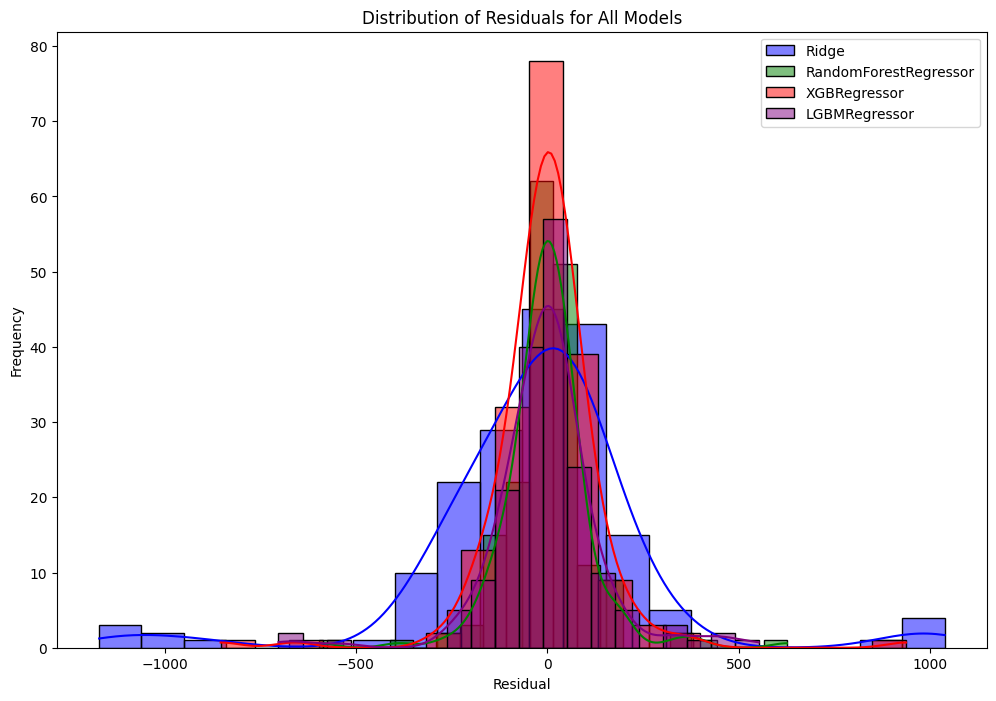

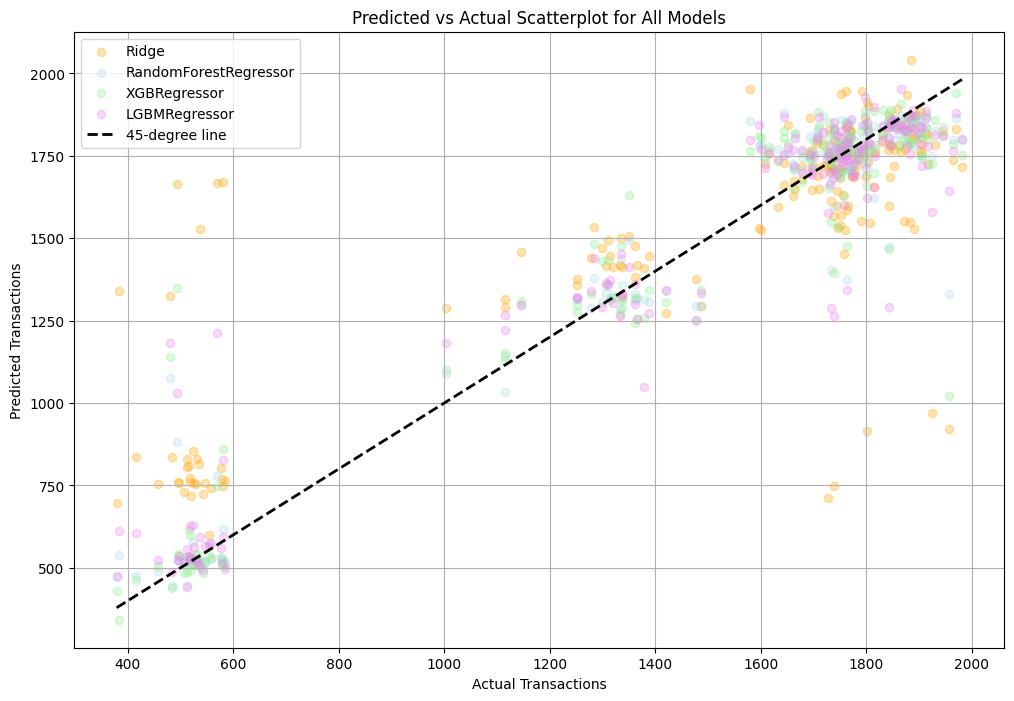

Visualizations for Ridge


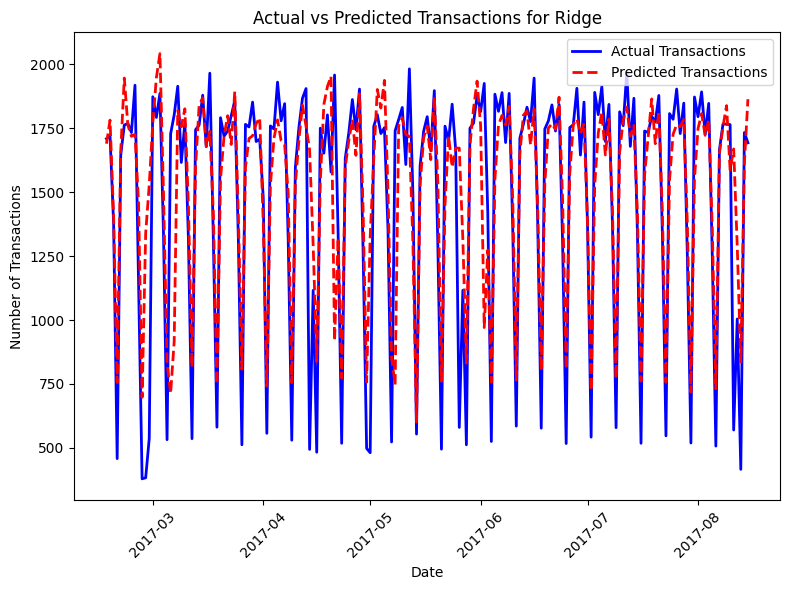

Visualizations for RandomForestRegressor


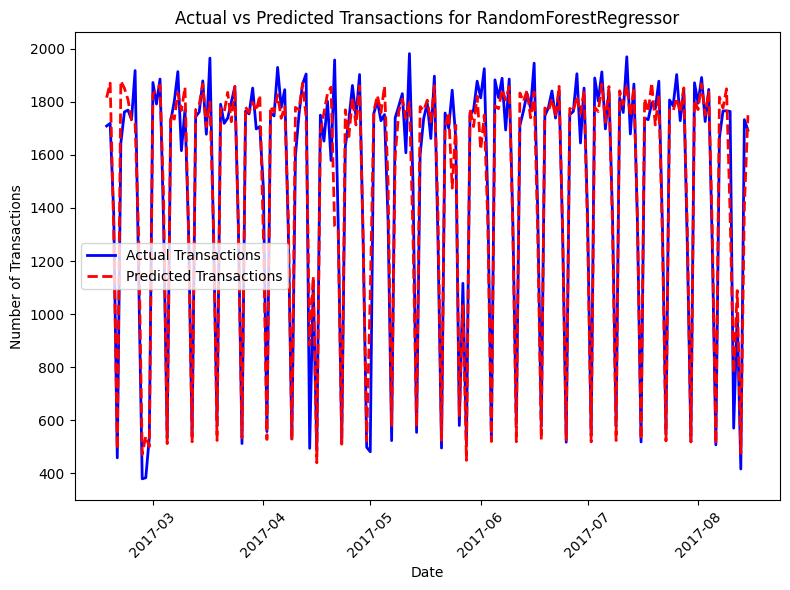

Visualizations for XGBRegressor


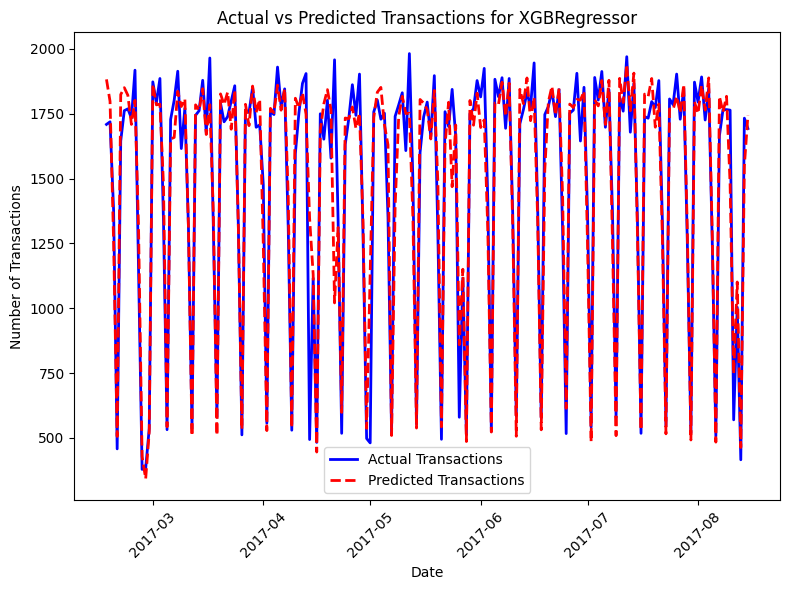

Visualizations for LGBMRegressor


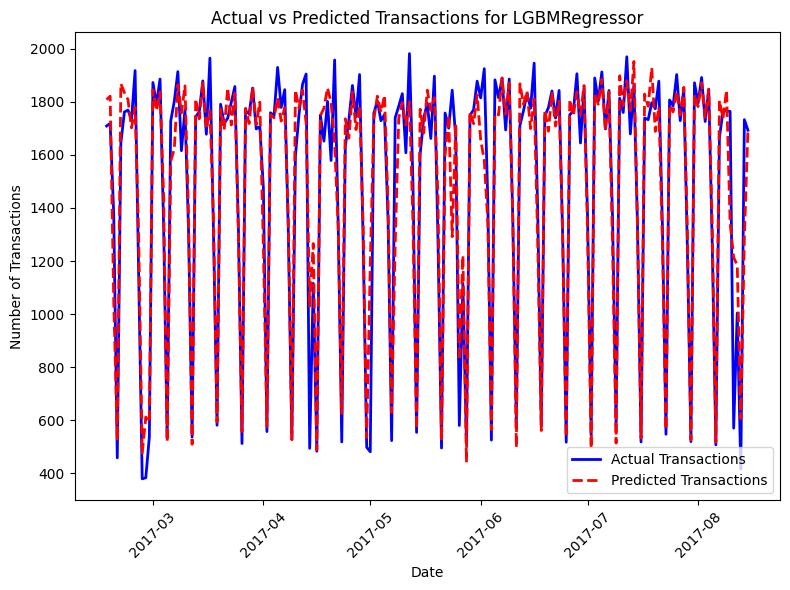

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
%matplotlib inline


# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Encode 'holiday' if it exists and is categorical
if 'holiday' in df.columns:
    le = LabelEncoder()
    df['holiday_encoded'] = le.fit_transform(df['holiday'])
    df.drop(['holiday'], axis=1, inplace=True)

# # Impute missing values for 'dcoilwtico'
# if 'dcoilwtico' in df.columns:
#     df['dcoilwtico'].fillna(df['dcoilwtico'].median(), inplace=True)

# Generate lagged features for transactions and dcoilwtico
for lag in range(1, 8):
    df[f'transactions_lag_{lag}'] = df['transactions'].shift(lag)
    df[f'dcoilwtico_lag_{lag}'] = df['dcoilwtico'].shift(lag)

# Forward fill to handle any remaining NaN values after lagging
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)  # Backward fill just in case

# Split the dataset into training and test sets
split_date = df.index.max() - pd.DateOffset(months=6)
train = df.loc[df.index <= split_date]
test = df.loc[df.index > split_date]

X_train = train.drop(['transactions'], axis=1)
y_train = train['transactions']
X_test = test.drop(['transactions'], axis=1)
y_test = test['transactions']

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Combine models and parameters for GridSearchCV including Ridge Regression
models_params = {
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': [0.1, 1.0, 10.0, 100.0]}
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'params': {'n_estimators': [50, 100], 'max_depth': [5, 10]}
    },
    'XGBRegressor': {
        'model': XGBRegressor(),
        'params': {'n_estimators': [50, 100], 'max_depth': [5, 10]}
    },
    'LGBMRegressor': {
        'model': LGBMRegressor(),
        'params': {'n_estimators': [50, 100], 'max_depth': [5, 10]}
    }
}

# Initialize storage for results and best models
results = {}
best_models = {}

# Model training and evaluation
for model_name, mp in models_params.items():
    grid_search = GridSearchCV(mp['model'], mp['params'], cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mape = calculate_mape(y_test, predictions)
    r_squared = r2_score(y_test, predictions)
    
    # Store results
    results[model_name] = {'RMSE': rmse, 'MAPE': mape, 'R^2': r_squared, 'Best Params': grid_search.best_params_}
    best_models[model_name] = best_model

# Display evaluation metrics for each model
for model_name, metrics in results.items():
    print(f"{model_name}: {metrics}")

# Plot the distribution of residuals for all models in one plot
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple']  # Define colors for each model
model_names = list(best_models.keys())  # Convert dict_keys to a list for indexing
for i, (model_name, model) in enumerate(best_models.items()):
    predictions = model.predict(X_test)
    residuals = y_test - predictions
    sns.histplot(residuals, kde=True, label=model_name, bins=20, alpha=0.5, color=colors[i])

plt.title('Distribution of Residuals for All Models')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.legend()
plt.show()  # Show the plot

# Visualization for multiple models: Scatterplot for Predicted vs Actual Transactions in one figure
plt.figure(figsize=(12, 8))
colors = ['orange', 'lightblue', 'lightgreen', 'violet']  # Adjusted colors for visibility
for i, model_name in enumerate(model_names):
    model = best_models[model_name]
    predictions = model.predict(X_test)
    plt.scatter(y_test, predictions, alpha=0.3, label=model_name, color=colors[i])  # Adjust alpha for transparency

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='45-degree line')
plt.xlabel('Actual Transactions')
plt.ylabel('Predicted Transactions')
plt.title('Predicted vs Actual Scatterplot for All Models')
plt.legend()
plt.grid(True)
plt.show()  # Show the plot

# Visualization for each model: Actual vs Predicted Transactions side by side
for i, model_name in enumerate(model_names):
    print(f"Visualizations for {model_name}")
    model = best_models[model_name]
    predictions = model.predict(X_test)
    
    fig, ax = plt.subplots(figsize=(8, 6))  # Single plot for Actual vs Predicted Transactions
    
    # Plot of Actual vs Predicted Transactions Over Time
    ax.plot(test.index, y_test, label='Actual Transactions', color='blue', linestyle='-', marker='', lw=2)
    ax.plot(test.index, predictions, label='Predicted Transactions', color='red', linestyle='--', marker='', lw=2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Transactions')
    ax.set_title(f'Actual vs Predicted Transactions for {model_name}')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()  # Show the plot for each model


A different method based on a time-implicit regression model is applied on the transactions of store 1. It generates the lagged features for transactions and the oil price. Four models are applied, including the Ridge, Random Forest, XGBoost, and LGBM models. For each model, the predicted vs the actual scatterplot, the distribution of residuals, and the redicted vs actual transactions across time axis are plotted. The evaluation metrics including RMSE, MAPE, R-squared are calculated. Overall, the random forest model produces the best result. The the result is better than the one created by previous model - the classical time series forest using ARIMA method. 

<a id="b.3"></a>
## b.3 Time-implicit regression model on store transactions

The above code applies the same time-impicit regression method on the rest of stores. RMSE, MAPE, R-squared are calculated. 

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import os

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100

def process_store_transactions(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    if 'holiday' in df.columns:
        le = LabelEncoder()
        df['holiday_encoded'] = le.fit_transform(df['holiday'])
        df.drop(['holiday'], axis=1, inplace=True)

    for lag in range(1, 8):
        df[f'transactions_lag_{lag}'] = df['transactions'].shift(lag)
        if 'dcoilwtico' in df.columns:
            df[f'dcoilwtico_lag_{lag}'] = df['dcoilwtico'].shift(lag)

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    split_date = df.index.max() - pd.DateOffset(months=6)
    train = df.loc[df.index <= split_date]
    test = df.loc[df.index > split_date]

    X_train = train.drop(['transactions'], axis=1)
    y_train = train['transactions']
    X_test = test.drop(['transactions'], axis=1)
    y_test = test['transactions']

    tscv = TimeSeriesSplit(n_splits=min(5, len(train) // 2 - 1))

    models_params = {
        'RandomForestRegressor': {
            'model': RandomForestRegressor(random_state=40),
            'params': {'n_estimators': [10, 50], 'max_depth': [5, 10]}
        },
        'XGBRegressor': {
            'model': XGBRegressor(),
            'params': {'n_estimators': [10, 50], 'max_depth': [5, 10]}
        },
        'LGBMRegressor': {
            'model': LGBMRegressor(),
            'params': {'n_estimators': [10, 50], 'max_depth': [5, 10]}
        },
        'LinearRegression': {
            'model': LinearRegression(),
            'params': {}
        }
    }

    results = {}
    for model_name, mp in models_params.items():
        if model_name == 'LinearRegression':
            model = mp['model'].fit(X_train, y_train)
            predictions = model.predict(X_test)
            best_params = 'N/A'
        else:
            grid_search = GridSearchCV(mp['model'], mp['params'], cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_
            predictions = model.predict(X_test)
            best_params = grid_search.best_params_
        
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mape = calculate_mape(y_test, predictions)
        r_squared = r2_score(y_test, predictions)
        
        results[model_name] = {'RMSE': rmse, 'MAPE': mape, 'R^2': r_squared, 'Best Params': best_params}

    return results

directory_path = '/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/'
excluded_stores = ['store_53', 'store_20', 'store_29', 'store_21', 'store_42', 'store_22', 'store_52']

all_results = []
file_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) 
              if f.startswith('store_') and f.endswith('_transactions_final.csv') 
              and all(ex_store not in f for ex_store in excluded_stores)]

for path in file_paths:
    store_name = os.path.basename(path).split('_')[1]  # Adjust based on file naming convention
    results = process_store_transactions(path)
    for model, metrics in results.items():
        metrics.update({'Store': store_name, 'Model': model})
        all_results.append(metrics)

results_df = pd.DataFrame(all_results)

# Identify the best model for each store based on RMSE
results_df['Best'] = results_df.groupby('Store')['MAPE'].transform(lambda x: x == x.min())

print("Comprehensive Results:")
print(results_df)

best_models = results_df[results_df['Best']]
print("\nBest Model for Each Store:")
print(best_models[['Store', 'Model', 'RMSE', 'MAPE', 'R^2', 'Best Params']])


Comprehensive Results:
           RMSE      MAPE       R^2                            Best Params   
0     62.880294  7.915213  0.092918   {'max_depth': 5, 'n_estimators': 50}  \
1     61.469590  7.710774  0.133161   {'max_depth': 5, 'n_estimators': 10}   
2     63.773017  7.914135  0.066979   {'max_depth': 5, 'n_estimators': 50}   
3     63.450728  8.038776  0.076385                                    N/A   
4    126.419755  5.200361  0.322246  {'max_depth': 10, 'n_estimators': 50}   
..          ...       ...       ...                                    ...   
183   81.111295  9.479482 -0.035815                                    N/A   
184  181.510830  5.178133  0.494171  {'max_depth': 10, 'n_estimators': 50}   
185  191.609014  5.430214  0.436323   {'max_depth': 5, 'n_estimators': 10}   
186  180.128991  5.433682  0.501843  {'max_depth': 10, 'n_estimators': 50}   
187  216.754483  6.887244  0.278669                                    N/A   

    Store                  Model   Best 

<a id="b.4"></a>
## b.4 Random Forest, XGboost, LightGBM, linear Regression, Prophet models on store transactions

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from prophet import Prophet

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100

def process_store_transactions_combined(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    if 'holiday' in df.columns:
        le = LabelEncoder()
        df['holiday_encoded'] = le.fit_transform(df['holiday'])
        df.drop(['holiday'], axis=1, inplace=True)

    for lag in range(1, 8):
        df[f'transactions_lag_{lag}'] = df['transactions'].shift(lag)
        if 'dcoilwtico' in df.columns:
            df[f'dcoilwtico_lag_{lag}'] = df['dcoilwtico'].shift(lag)

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    split_date = df.index.max() - pd.DateOffset(months=6)
    train = df.loc[df.index <= split_date]
    test = df.loc[df.index > split_date]

    X_train = train.drop(['transactions'], axis=1)
    y_train = train['transactions']
    X_test = test.drop(['transactions'], axis=1)
    y_test = test['transactions']

    # Initialize results dictionary
    results = []

    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=min(5, len(train) // 2 - 1))

    # Machine Learning Models
    models_params = {
        'RandomForestRegressor': {
            'model': RandomForestRegressor(random_state=40),
            'params': {'n_estimators': [10, 50], 'max_depth': [5, 10]}
        },
        'XGBRegressor': {
            'model': XGBRegressor(),
            'params': {'n_estimators': [10, 50], 'max_depth': [5, 10]}
        },
        'LGBMRegressor': {
            'model': LGBMRegressor(),
            'params': {'n_estimators': [10, 50], 'max_depth': [5, 10]}
        },
        'LinearRegression': {
            'model': LinearRegression(),
            'params': {}
        }
    }

    # Process each model
    for model_name, mp in models_params.items():
        if model_name == 'LinearRegression':
            model = mp['model'].fit(X_train, y_train)
            predictions = model.predict(X_test)
            best_params = 'N/A'
        else:
            grid_search = GridSearchCV(mp['model'], mp['params'], cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_
            predictions = model.predict(X_test)
            best_params = grid_search.best_params_
        
        mape = calculate_mape(y_test, predictions)
        results.append({'Algorithm': model_name, 'MAPE': mape, 'Best Params': best_params})

    # Prophet Model
    df_prophet = df.reset_index()[['date', 'transactions', 'holiday_encoded']].rename(columns={'date': 'ds', 'transactions': 'y'})
    model_prophet = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
    if 'holiday_encoded' in df_prophet.columns:
        model_prophet.add_regressor('holiday_encoded')
    model_prophet.fit(df_prophet[df_prophet['ds'] <= split_date])

    future = model_prophet.make_future_dataframe(periods=len(test))
    if 'holiday_encoded' in df_prophet.columns:
        future = pd.merge(future, df_prophet[['ds', 'holiday_encoded']], on='ds', how='left')
    future['holiday_encoded'].fillna(0, inplace=True)

    forecast = model_prophet.predict(future)
    predicted_prophet = forecast['yhat'][-len(test):].values

    mape_prophet = calculate_mape(y_test, predicted_prophet)
    results.append({'Algorithm': 'Prophet', 'MAPE': mape_prophet, 'Best Params': 'N/A'})

    # Add time series ID to results
    time_series_id = os.path.basename(file_path).split('_')[1]
    for result in results:
        result['Time Series ID'] = time_series_id

    return results

# Process each file and compile results
all_results = []
directory_path = '/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/'  # Update this path to your actual directory
excluded_stores = ['store_53', 'store_20', 'store_29', 'store_21', 'store_42', 'store_22', 'store_52']

file_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path)
              if f.startswith('store_') and f.endswith('_transactions_final.csv')
              and all(ex_store not in f for ex_store in excluded_stores)]

for path in file_paths:
    all_results.extend(process_store_transactions_combined(path))

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(all_results)

# Ensure the 'Best' column is created by marking the rows with the minimum MAPE for each Time Series ID
results_df['Best'] = results_df.groupby('Time Series ID')['MAPE'].transform(lambda x: x == x.min())

# Display comprehensive results
print("Comprehensive Results:")
print(results_df.sort_values(by=['Time Series ID', 'MAPE']))

# Now, filtering by the 'Best' column should work as expected
best_models = results_df[results_df['Best']].copy()
print("\nBest Model for Each Time Series:")
print(best_models[['Time Series ID', 'Algorithm', 'MAPE', 'Best Params']].sort_values(by='MAPE'))

# New section: Print out the MAPE for all models for each store, sorted by MAPE within each store
print("\nMAPE for All Models by Store, Sorted by MAPE:")
grouped = results_df.groupby('Time Series ID')
for store, group in grouped:
    print(f"\nStore: {store}")
    sorted_group = group.sort_values(by='MAPE')
    print(sorted_group[['Algorithm', 'MAPE']])

15:34:25 - cmdstanpy - INFO - Chain [1] start processing
15:34:26 - cmdstanpy - INFO - Chain [1] done processing
15:34:28 - cmdstanpy - INFO - Chain [1] start processing
15:34:28 - cmdstanpy - INFO - Chain [1] done processing
15:34:30 - cmdstanpy - INFO - Chain [1] start processing
15:34:30 - cmdstanpy - INFO - Chain [1] done processing
15:34:32 - cmdstanpy - INFO - Chain [1] start processing
15:34:32 - cmdstanpy - INFO - Chain [1] done processing
15:34:34 - cmdstanpy - INFO - Chain [1] start processing
15:34:34 - cmdstanpy - INFO - Chain [1] done processing
15:34:36 - cmdstanpy - INFO - Chain [1] start processing
15:34:36 - cmdstanpy - INFO - Chain [1] done processing
15:34:38 - cmdstanpy - INFO - Chain [1] start processing
15:34:38 - cmdstanpy - INFO - Chain [1] done processing
15:34:40 - cmdstanpy - INFO - Chain [1] start processing
15:34:40 - cmdstanpy - INFO - Chain [1] done processing
15:34:42 - cmdstanpy - INFO - Chain [1] start processing
15:34:42 - cmdstanpy - INFO - Chain [1]

Comprehensive Results:
                 Algorithm       MAPE                            Best Params   
61            XGBRegressor   8.013120   {'max_depth': 5, 'n_estimators': 10}  \
62           LGBMRegressor   8.209663  {'max_depth': 10, 'n_estimators': 50}   
60   RandomForestRegressor   8.679505   {'max_depth': 5, 'n_estimators': 50}   
64                 Prophet  12.117052                                    N/A   
63        LinearRegression  20.228400                                    N/A   
..                     ...        ...                                    ...   
115  RandomForestRegressor   5.941674  {'max_depth': 10, 'n_estimators': 50}   
117          LGBMRegressor   6.037841  {'max_depth': 10, 'n_estimators': 50}   
116           XGBRegressor   6.208490   {'max_depth': 5, 'n_estimators': 10}   
118       LinearRegression   6.948919                                    N/A   
119                Prophet   6.992226                                    N/A   

    Time Series 

The above code applies Random Forest, XGBoost, LightGBM, linear regression, and prophet models on store transactions. The best model is the one with the lowest MAPE within all five models. The store 12 achieves the lowest MAPE of 4.1% with XGBoost method. The store 30 achieves the highest MAPE of 11.7% with XGBoost method. 

In addition, for each store, the MAPE of five models are shown, starting from the model with the lowest MAPE. 

<a id="b.5"></a>
## b.5 Auto-ml model on store transactions

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from supervised.automl import AutoML
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Update to the directory containing store files
data_directory = '/Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/'  

# List of stores to exclude from the analysis
excluded_stores = ['store_53', 'store_20', 'store_29', 'store_21', 'store_42', 'store_22', 'store_52']

# Generate list of store transaction files, excluding the specified stores
store_files = [f for f in os.listdir(data_directory) if f.startswith('store_') and f.endswith('_transactions_final.csv') and all(excluded_store not in f for excluded_store in excluded_stores)]

results_summary = []

for store_file in store_files:
    file_path = os.path.join(data_directory, store_file)
    print(f"Processing {file_path}...")
    
    # Load the dataset
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Encode 'holiday' if it exists and is categorical
    if 'holiday' in df.columns:
        le = LabelEncoder()
        df['holiday_encoded'] = le.fit_transform(df['holiday'])
        df.drop(['holiday'], axis=1, inplace=True)

    # Fill missing values if necessary
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    split_date = df.index.max() - pd.DateOffset(months=6)
    train = df.loc[df.index <= split_date]
    test = df.loc[df.index > split_date]

    X_train = train.drop(['transactions'], axis=1)
    y_train = train['transactions']
    X_test = test.drop(['transactions'], axis=1)
    y_test = test['transactions']

    automl = AutoML(mode="Explain", total_time_limit=3600)
    automl.fit(X_train, y_train)

    predictions = automl.predict(X_test)




Processing /Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/store_32_transactions_final.csv...
AutoML directory: AutoML_806
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 113.056498 trained in 0.23 seconds
2_DecisionTree rmse 119.927416 trained in 3.3 seconds
3_Linear rmse 111.674818 trained in 2.27 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 113.576106 trained in 2.23 seconds
5_Default_NeuralNetwork rmse 111.675331 trained in 1.95 seconds
6_Default_RandomForest rmse 120.28932 trained in 0.57 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 111.292601 traine

* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 219.842327 trained in 0.94 seconds
5_Default_NeuralNetwork rmse 213.791663 trained in 0.56 seconds
6_Default_RandomForest rmse 230.151901 trained in 0.98 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 207.488453 trained in 0.08 seconds
AutoML fit time: 7.48 seconds
AutoML best model: Ensemble
Processing /Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/store_49_transactions_final.csv...
AutoML directory: AutoML_814
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 675.868255 trained in 0.42 seconds
2_DecisionTree rmse 572.03

1_Baseline rmse 751.782636 trained in 0.64 seconds
2_DecisionTree rmse 736.880382 trained in 1.09 seconds
3_Linear rmse 731.187658 trained in 1.19 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 736.876828 trained in 1.38 seconds
5_Default_NeuralNetwork rmse 758.619111 trained in 1.04 seconds
6_Default_RandomForest rmse 736.803054 trained in 1.24 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 727.687966 trained in 0.08 seconds
AutoML fit time: 9.9 seconds
AutoML best model: Ensemble
Processing /Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/store_30_transactions_final.csv...
AutoML directory: AutoML_822
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algori

1_Baseline rmse 372.560989 trained in 1.77 seconds
2_DecisionTree rmse 376.577804 trained in 2.31 seconds
3_Linear rmse 362.152841 trained in 2.67 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 369.270842 trained in 4.59 seconds
5_Default_NeuralNetwork rmse 367.079558 trained in 2.69 seconds
6_Default_RandomForest rmse 372.205865 trained in 2.16 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 362.152841 trained in 0.08 seconds
AutoML fit time: 19.94 seconds
AutoML best model: 3_Linear
Processing /Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/store_39_transactions_final.csv...
AutoML directory: AutoML_830
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algo

1_Baseline rmse 201.080499 trained in 3.23 seconds
2_DecisionTree rmse 186.630289 trained in 3.5 seconds
3_Linear rmse 178.152804 trained in 3.53 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 182.368369 trained in 3.75 seconds
5_Default_NeuralNetwork rmse 178.074854 trained in 3.43 seconds
6_Default_RandomForest rmse 177.840365 trained in 3.86 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 175.560826 trained in 0.08 seconds
AutoML fit time: 24.6 seconds
AutoML best model: Ensemble
Processing /Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/store_14_transactions_final.csv...
AutoML directory: AutoML_838
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algori

1_Baseline rmse 411.617752 trained in 4.64 seconds
2_DecisionTree rmse 358.147236 trained in 4.76 seconds
3_Linear rmse 390.022582 trained in 4.81 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 363.640369 trained in 5.05 seconds
5_Default_NeuralNetwork rmse 375.662289 trained in 4.75 seconds
6_Default_RandomForest rmse 354.625021 trained in 5.27 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 353.383593 trained in 0.08 seconds
AutoML fit time: 32.74 seconds
AutoML best model: Ensemble
Processing /Users/paperclip/Documents/MASTER/Data Scientist Springboard/3rd Capstone Project/Store-sales-time-series-forecasting/store_12_transactions_final.csv...
AutoML directory: AutoML_846
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algo

The above code applies Auto-ml model on store transactions. It recommends the best model for each store transaction. 

<a id="b.6"></a>
## b.6 Summary

1. Firstly, ARIMA model is applied on store 1 transaction. RMSE, MAPE, and r-squared are calculated. And the forcast and the predicted are ploted for the last 6 months. 

2. Then the implicit regression method is applied on the same dataset. Ridge, Random Forest, XGBoost and LightGBM methods are implemented. RMSE, MAPE, and r-squared are calculated. Their distribution of residules are overlayed for comparison. The predicted vs actual are ploted for all models. And the forast and the predicted are ploted. Overall, any implicit regression method performs better than the ARIMA model. Random Forest model has the lowest MAPE of 6.1%.

3. The implicit regression method plus the prophet model are applied for the remaining store transactions. For each store, the best model is selected from Linear regression, Random Forest, XGBoost, LightGBM, and Prophet based on which model provides the lowest MAPE. In addition, for each store, the MAPE of each model is shown. 

4. Lastly, the AutoML tool is applied on store transactions. 